<a href="https://colab.research.google.com/github/agusxpro/msit/blob/big-data/th_codeR6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = "https://drive.google.com/file/d/19WUTs8nKJ185YjXJl8_sSi0kiWAI2Xh9/view"

# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('dataset.csv')

**LOAD THE DATASET**

In [4]:
# Load the data from the CSV file
import pandas as pd
df_init = pd.read_csv('dataset.csv')

**REMOVING MISSING VALUE**

In [5]:
# Remove any rows with missing values
df = df_init.dropna()

**REMOVING OUTLIER WITH COVARIANCE ESTIMATOR**

In [6]:
import pandas as pd
from sklearn.ensemble import IsolationForest

model = IsolationForest()
model.fit(df)

# Predict outliers
outliers = model.predict(df) == -1

# Store the final dataset without outliers as a DataFrame
df_clean = df[~outliers]

# Print the number of outliers detected and the shape of the final dataset
print("Number of outliers:", sum(outliers))
print("Shape of final dataset:", df_clean.shape)
print("Shape of original dataset:", df.shape)

# Optionally, you can save the final dataset to a new CSV file
#X_clean.to_csv("final_dataset.csv", index=False)

Number of outliers: 1350
Shape of final dataset: (7050, 82)
Shape of original dataset: (8400, 82)


In [7]:
# Separate target variable
X = df_clean.drop('BOILER EFFICIENCY', axis=1) 
y = df_clean['BOILER EFFICIENCY']

In [8]:
X.shape

(7050, 81)

In [9]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Change to df
dfX = pd.DataFrame(X)

# Create a new dataframe to store the VIF scores
vif_df = pd.DataFrame(columns=['Feature', 'VIF'])

# Iterate through each feature in the dataframe and calculate its VIF score
for i in range(len(dfX.columns)):
    vif = variance_inflation_factor(dfX.values, i)
    vif_df.loc[i] = [dfX.columns[i], vif]

# Select the features with VIF score less than 10 and store them in a new dataframe
selected_features_df = vif_df.loc[vif_df['VIF'] < 10]

# Extract the names of the selected features
selected_features = selected_features_df['Feature'].values

# Create a new dataframe with the selected features
selected_dfX = dfX[selected_features]

In [10]:
selected_dfX.shape

(7050, 8)

In [11]:
# Display the ranked result of the selected features
print(selected_features_df.sort_values('VIF', ascending=True))

                        Feature       VIF
33  PULV. F PRIMARY AIR TEMP. 1  1.375802
11           MAIN STEAM A TEMP.  1.528223
12           MAIN STEAM B TEMP.  1.697198
14            HRH STEAM TEMP. B  1.862353
75                  STB STM FLW  2.164788
71      ECON OTL A GAS O2 S VLU  2.742873
72      ECON OTL B GAS O2 S VLU  2.860734
16       PSH SPRY WTR FLW S VLU  4.135506


In [12]:
# Print the selected features
print(selected_dfX.columns)
print(selected_dfX.shape)

Index(['MAIN STEAM A TEMP.', 'MAIN STEAM B TEMP.', 'HRH STEAM TEMP. B',
       'PSH SPRY WTR FLW S VLU', 'PULV. F PRIMARY AIR TEMP. 1',
       'ECON OTL A GAS O2 S VLU', 'ECON OTL B GAS O2 S VLU', 'STB STM FLW'],
      dtype='object')
(7050, 8)


In [13]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prep_scaled = scaler.fit_transform(selected_dfX)
y_prep_scaled = y

In [14]:
def feature_selection_RFE(x_var, y_var, n_features, model_types):
  # Create RFE estimator with Ridge Regression estimator and 15 features
  rfe = RFE(estimator=model_types, n_features_to_select=n_features)

  # Fit RFE estimator to X and y
  rfe.fit(x_var, y_var)

  # Get selected feature indices
  sel_rfe = rfe.get_support(indices=True)

  # Get selected feature names
  names_sel_rfe = X.columns[sel_rfe]

  # Print
  print(names_sel_rfe)
  print("Length :",len(names_sel_rfe))
  return names_sel_rfe

In [15]:
# Load necessary packages
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#Selected Feature
n = 10

# Estimator
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()
decision = DecisionTreeRegressor()
forest = RandomForestRegressor()

# Input to model
rfe_names = feature_selection_RFE(X_prep_scaled, y_prep_scaled, n, linear)

Index(['GENERATOR OUTPUT POWER', 'DESUPERHEATER A OUTLET WATER TEMP.',
       'DESUPERHEATER B OUTLET WATER TEMP.', 'ECON INL FW FLW S VLU',
       'FW FLW (EXC. SH SPRAY)', 'ECO INLET WATER TEMP S VLU',
       'FEGT OUTLET TEMPERATURE S VLU',
       'PRIMARY SUPERHEATER A OUTLET STEAM TEMP.'],
      dtype='object')
Length : 8


In [16]:
# Store final dataset with selected features
X_rfe = df_clean[rfe_names]
print("X_rfe shape:", X_rfe.shape)
print("y shape:", y.shape)

X_rfe shape: (7050, 8)
y shape: (7050,)


In [17]:
# Join preprocessed data and target date into a single dataframe (Final Dataset)
df_prep_final = pd.concat([y, X_rfe],axis=1)
print(df_prep_final.columns)

Index(['BOILER EFFICIENCY', 'GENERATOR OUTPUT POWER',
       'DESUPERHEATER A OUTLET WATER TEMP.',
       'DESUPERHEATER B OUTLET WATER TEMP.', 'ECON INL FW FLW S VLU',
       'FW FLW (EXC. SH SPRAY)', 'ECO INLET WATER TEMP S VLU',
       'FEGT OUTLET TEMPERATURE S VLU',
       'PRIMARY SUPERHEATER A OUTLET STEAM TEMP.'],
      dtype='object')


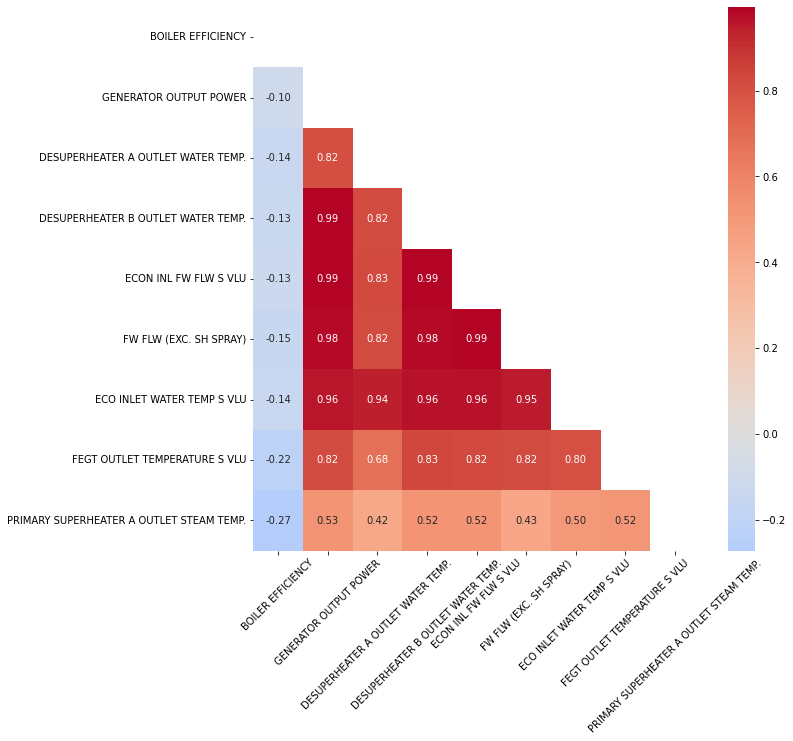

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_prep_final.corr()

# Create a mask to display only the lower triangle of the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Create the heatmap using seaborn library
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt='.2f', ax=ax)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

## **Storing the FINAL preprocessed Dataset**

In [19]:
# Final preprocessed dataset
X_final = X_rfe
y_final = y

# Save final dataset to CSV (check in the Colab's file folder)
#df_prep_final.to_csv('final_prep_dataset.csv', index=False)

print("Dataset final shape : ",df_prep_final.shape)
df_prep_final.head(10)

Dataset final shape :  (7050, 9)


,BOILER EFFICIENCY,GENERATOR OUTPUT POWER,DESUPERHEATER A OUTLET WATER TEMP.,DESUPERHEATER B OUTLET WATER TEMP.,ECON INL FW FLW S VLU,FW FLW (EXC. SH SPRAY),ECO INLET WATER TEMP S VLU,FEGT OUTLET TEMPERATURE S VLU,PRIMARY SUPERHEATER A OUTLET STEAM TEMP.
436,86.933,590.706,256.9,256.800,1583.257,1501.178,255.523,763.053,459.230
450,86.378,593.385,257.6,257.700,1590.877,1511.857,256.165,767.348,467.850
454,86.565,594.873,257.2,257.100,1591.751,1556.028,255.938,784.416,457.208
458,86.792,596.940,257.4,257.200,1577.146,1500.869,255.965,764.464,450.100
468,86.965,601.018,258.6,258.417,1630.372,1559.435,257.071,793.562,461.120
469,86.962,601.369,258.6,258.500,1624.280,1540.718,257.221,793.681,461.551
472,87.162,602.570,257.7,257.600,1611.922,1558.897,256.418,771.646,445.378
474,86.964,603.713,258.8,258.600,1621.387,1535.280,257.224,799.200,464.558
488,87.128,612.284,259.0,258.978,1655.239,1570.670,257.655,750.397,457.013
511,87.533,625.397,260.2,260.200,1674.071,1590.624,258.815,800.202,453.500


**SPLIT THE DATASET INTO TRAINING AND TESTING**

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate target variable
X2 = df_prep_final.drop('BOILER EFFICIENCY', axis=1) 
y2 = df_prep_final['BOILER EFFICIENCY']

# Split the dataset 20/80 into test and training sets
X_model, X_test, y_model, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Split the dataset 30/70 into training and validation sets
X_training, X_valid, y_training, y_valid = train_test_split(X_model, y_model, test_size=0.3, random_state=42)

# Print the shapes of the resulting datasets
print("X_model shape:", X_model.shape)
print("y_model shape:", y_model.shape)
print("X_train shape:", X_training.shape)
print("X_val shape:", X_valid.shape)
print("y_train shape:", y_training.shape)
print("y_val shape:", y_valid.shape)


X_model shape: (5640, 8)
y_model shape: (5640,)
X_train shape: (3948, 8)
X_val shape: (1692, 8)
y_train shape: (3948,)
y_val shape: (1692,)


**NORMALIZATION**

This code loads the selected features from the "selected_features.csv" file that was saved in the previous step. The squeeze=True argument is used to return the feature names as a Pandas Series instead of a DataFrame.

The MinMaxScaler from scikit-learn is used to normalize the selected features to the range [0, 1]. The fit_transform method is used to fit the scaler to the training data and transform it, while the transform method is used to transform the test data using the same scaling factors learned from the training data.

The normalized training and test data are stored in the X_train_norm and X_val_norm variables, respectively.

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the selected features using MinMaxScaler
scaler = MinMaxScaler()
X_training_norm = scaler.fit_transform(X_training)
X_valid_norm = scaler.transform(X_valid)

# Check the input shape
print("Input shape : ",X_training_norm.shape)
print("Output shape : ",X_valid_norm.shape)

Input shape :  (3948, 8)
Output shape :  (1692, 8)


In [22]:
if len(pd.DataFrame(X_training_norm).columns) >=8:
  # Input
  neuron = 220
  kernel = 3
  print("Dataset dimension acepted")
else:
  print("Dataset dimension too low, execution stopped!")
  exit()

Dataset dimension acepted


In [23]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError

# Reshape the input data to be suitable for CNN
X_train = X_training_norm.reshape(X_training_norm.shape[0], X_training_norm.shape[1], 1)
X_val = X_valid_norm.reshape(X_valid_norm.shape[0], X_valid_norm.shape[1], 1)
y_train = y_training
y_val = y_valid

length = len(X_training.columns)

# Define the model architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=kernel, activation='relu', input_shape=(length,1)))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=kernel, activation='relu'))
model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=kernel, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
for i in range(length):
    model.add(tf.keras.layers.Dense(neuron, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Compile the model with appropriate loss function and metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae', RootMeanSquaredError()])

# Train the model and store the training history
history = model.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_data=(X_val,y_val))

Epoch 1/150
124/124 [==============================] - 5s 19ms/step - loss: 747.6780 - mse: 747.6780 - mae: 13.4149 - root_mean_squared_error: 27.3437 - val_loss: 0.9748 - val_mse: 0.9748 - val_mae: 0.7304 - val_root_mean_squared_error: 0.9873
Epoch 2/150
124/124 [==============================] - 2s 16ms/step - loss: 0.7477 - mse: 0.7477 - mae: 0.6297 - root_mean_squared_error: 0.8647 - val_loss: 0.6144 - val_mse: 0.6144 - val_mae: 0.6102 - val_root_mean_squared_error: 0.7838
Epoch 3/150
124/124 [==============================] - 3s 25ms/step - loss: 0.3664 - mse: 0.3664 - mae: 0.4406 - root_mean_squared_error: 0.6053 - val_loss: 0.2716 - val_mse: 0.2716 - val_mae: 0.4098 - val_root_mean_squared_error: 0.5211
Epoch 4/150
124/124 [==============================] - 2s 17ms/step - loss: 0.2336 - mse: 0.2336 - mae: 0.3594 - root_mean_squared_error: 0.4834 - val_loss: 0.1666 - val_mse: 0.1666 - val_mae: 0.3214 - val_root_mean_squared_error: 0.4082
Epoch 5/150
124/124 [=====================

In [24]:
import plotly.express as px

# Evaluate the model on the testing set
score = model.evaluate(X_val, y_val)

# Extract the losses from the training history
losses = history.history['loss']
val_losses = history.history['val_loss']

# Create the plot
fig = px.line(
      history.history, x=history.epoch, y=['loss', 'val_loss'], 
      labels={'value': 'Loss', 'variable': 'Dataset'})

# set the scale for x and y axis
fig.update_yaxes(range=[-1, 10])

# add axis labels and title
fig.update_layout(
    title='Trend of Training process',
    xaxis_title='Epoch Number',
    yaxis_title='Loss', width=1100, height=500, template="ggplot2")

# show the plot
fig.show()

# Print the evaluation score
print(f'Validation loss: {score[0]}')
print(f'Validation MAE: {score[2]}')
print(f'Validation MSE: {score[1]}')
print("Validation RMSE: ", np.sqrt(score[1]))

53/53 [==============================] - 0s 7ms/step - loss: 0.0368 - mse: 0.0368 - mae: 0.1485 - root_mean_squared_error: 0.1918


Validation loss: 0.03679409623146057
Validation MAE: 0.1485123485326767
Validation MSE: 0.03679409623146057
Validation RMSE:  0.19181787255482888


In [25]:
def predict (X_var):
  import numpy as np
  from sklearn.preprocessing import MinMaxScaler
  
  # Normalize the selected features using MinMaxScaler
  scaler = MinMaxScaler()
  X_var_norm = scaler.fit_transform(X_var)

  # Reshape the input data to be suitable for CNN
  fX_unseen = X_var_norm.reshape(X_var_norm.shape[0], X_var_norm.shape[1], 1)

  # Evaluate the model on the test data
  fy_pred = model.predict(fX_unseen)
  return fy_pred

In [26]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the trained model
#model = tf.keras.models.load_model('model.h5')

# Evaluate the model on the test data
y_pred = predict(X_test)

# Scoring
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the scores
print(f"Testing MAE: {mae:.4f}")
print(f"Testing MSE: {mse:.4f}")
print(f"Testing RMSE: {rmse:.4f}")

45/45 [==============================] - 0s 3ms/step
Testing MAE: 0.1879
Testing MSE: 0.0643
Testing RMSE: 0.2535


In [27]:
def plotting_prediction (y_test_data, y_pred_data):
  import plotly.express as px
  # Create a table to compare the predicted and actual values
  compare_df = pd.DataFrame({'Actual': y_test_data, 'Predicted': y_pred_data.reshape(-1)})

  # create the scatter plot
  fig = px.scatter(compare_df, y='Actual', x='Predicted', trendline='ols', color='Actual',
                  color_continuous_scale='Viridis', opacity=0.7)

  # add axis labels and title
  fig.update_layout(
      title='Predicted vs Actual Values',
      yaxis_title='Actual Value',
      xaxis_title='Predicted Value', width=1000, height=1000)

  # show the plot
  fig.show()

In [28]:
plotting_prediction(y_test, y_pred)